In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import preprocessing
from collections import defaultdict, Counter
from nltk.util import ngrams
import collections
import nltk
import warnings
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import  precision_score, recall_score
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
uploaded = files.upload()


Saving surgeries to predict.csv to surgeries to predict.csv


In [ ]:
df = pd.read_csv('surgeries to predict.csv').drop(columns = ['Unnamed: 0'])
df.rename(columns = {'Surgery Type': 'surgery_type',
                     'Anesthesia Type': 'anesthesia_type',
                      'Age': 'age',
                      'BMI': 'bmi',
                     'DoctorID': 'doctor_id',
                     'AnaesthetistID': 'anaesthetist_id',
                     'Duration in Minutes': 'duration_in_minutes'
                    }, inplace= True)

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.1)

In [ ]:
surgery_type_encoder = OneHotEncoder()
train_surgery_type_transformed = surgery_type_encoder.fit_transform(train_df[['surgery_type']]).toarray().tolist()
train_df['surgery_type_encoded'] = train_surgery_type_transformed


In [ ]:
test_surgery_type_transformed = surgery_type_encoder.transform(test_df[['surgery_type']]).toarray().tolist()
test_df['surgery_type_encoded'] = test_surgery_type_transformed

In [ ]:
train_df.sample(3)

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes,surgery_type_encoded
6256,0,1,50,24,225707,691653,81,"[1.0, 0.0, 0.0, 0.0, 0.0]"
5041,4,0,34,21,920361,725848,151,"[0.0, 0.0, 0.0, 0.0, 1.0]"
463,4,1,44,35,718499,177499,169,"[0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
test_df.sample(3)

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes,surgery_type_encoded
6870,2,0,70,26,129991,173520,50,"[0.0, 0.0, 1.0, 0.0, 0.0]"
5044,4,0,67,28,703244,197337,167,"[0.0, 0.0, 0.0, 0.0, 1.0]"
3364,3,1,54,24,774229,168109,149,"[0.0, 0.0, 0.0, 1.0, 0.0]"


In [ ]:
class DataGenerator(Dataset):
    def __init__(self, df):
        self._df = df

    def __len__(self):
        return self._df.shape[0]

    def __getitem__(self, index):

        row = self._df.iloc[index]

        return  np.array(row['surgery_type_encoded']), row['anesthesia_type'], row['age'], row['bmi'], row['duration_in_minutes']

In [ ]:
train_data_generator = DataGenerator(train_df)
train_data_loader = DataLoader(train_data_generator, batch_size=128, shuffle=True, num_workers=0)


test_data_generator = DataGenerator(test_df)
test_data_loader = DataLoader(test_data_generator, batch_size=128, shuffle=False, num_workers=0)



In [ ]:
class DurationModel(torch.nn.Module):

  def __init__(self, surgery_type_number_of_values):

    super().__init__()

    number_of_features = surgery_type_number_of_values + 1 + 1 + 1
    self._bn1 = nn.BatchNorm1d(number_of_features)
    self._out1 = nn.Linear(number_of_features, 7)
    self._out2 = nn.Linear(7, 1)


  def forward(self, surgey_type_encoded, anesthesia_type, age, bmi):

    out = torch.cat((surgey_type_encoded, anesthesia_type, age, bmi), 1)
    out = self._bn1(out)
    out = self._out1(out)
    out = F.tanh(out)
    out = self._out2(out)

    return out

  def init_weights(self):
    self.init_fc()

  def init_fc(self):
    torch.nn.init.xavier_uniform_(self._out1.weight)
    self._out1.bias.data.fill_(0.01)

    torch.nn.init.xavier_uniform_(self._out2.weight)
    self._out2.bias.data.fill_(0.01)




In [ ]:
surgery_type_number_of_values = len(train_df.iloc[0]['surgery_type_encoded'])
surgery_type_number_of_values

5

In [ ]:

model = DurationModel(surgery_type_number_of_values).to(device)
model.init_weights()
#loss_fn = nn.MSELoss().to(device)
loss_fn = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for batch in range(800):
  l = 0.0
  c = 0.

  for surgery_type, anesthesia_type, age, bmi, target in train_data_loader:
    model.train()

    surgery_type = surgery_type.float().to(device)
    anesthesia_type = anesthesia_type.to(device).reshape(anesthesia_type.shape[0], -1)
    age = age.to(device).reshape(age.shape[0], -1)
    bmi = bmi.to(device).reshape(bmi.shape[0], -1)
    target = target.float().flatten().to(device)

    y_pred = model(surgery_type, anesthesia_type, age, bmi).flatten()


    loss = loss_fn(y_pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    c += 1
    l += loss.item()

  print((batch, c, l))


(0, 71.0, 8150.264694213867)
(1, 71.0, 8117.027992248535)
(2, 71.0, 8048.8289794921875)
(3, 71.0, 7938.337203979492)
(4, 71.0, 7822.005043029785)
(5, 71.0, 7710.3244552612305)
(6, 71.0, 7661.134834289551)
(7, 71.0, 7584.292610168457)
(8, 71.0, 7521.3175048828125)
(9, 71.0, 7480.085380554199)
(10, 71.0, 7420.714973449707)
(11, 71.0, 7373.723564147949)
(12, 71.0, 7337.41145324707)
(13, 71.0, 7292.087715148926)
(14, 71.0, 7250.894683837891)
(15, 71.0, 7205.455451965332)
(16, 71.0, 7153.525062561035)
(17, 71.0, 7122.952346801758)
(18, 71.0, 7074.8234939575195)
(19, 71.0, 7028.613052368164)
(20, 71.0, 6990.256980895996)
(21, 71.0, 6966.662796020508)
(22, 71.0, 6916.943092346191)
(23, 71.0, 6862.187797546387)
(24, 71.0, 6841.7535400390625)
(25, 71.0, 6783.592994689941)
(26, 71.0, 6752.068229675293)
(27, 71.0, 6705.6210861206055)
(28, 71.0, 6679.377899169922)
(29, 71.0, 6632.384101867676)
(30, 71.0, 6588.583435058594)
(31, 71.0, 6565.618949890137)
(32, 71.0, 6525.079513549805)
(33, 71.0, 6496

KeyboardInterrupt: ignored

In [ ]:
def pred(model, loader):

  model.eval()
  all_preds = []
  all_ys = []


  with torch.no_grad():

    for surgery_type, anesthesia_type, age, bmi, target in loader:

      surgery_type = surgery_type.float().to(device)
      anesthesia_type = anesthesia_type.to(device).reshape(anesthesia_type.shape[0], -1)
      age = age.to(device).reshape(age.shape[0], -1)
      bmi = bmi.to(device).reshape(bmi.shape[0], -1)
      target = target.tolist()
      y_pred = model(surgery_type, anesthesia_type, age, bmi).flatten()
      y_pred = y_pred.cpu().detach().numpy().tolist()
      all_preds.extend(y_pred)
      all_ys.extend(target)

  return pd.DataFrame(zip(all_ys, all_preds), columns = ['y', 'pred'])



In [ ]:
train_preds_df = pred(model, train_data_loader)


In [ ]:
test_preds_df = pred(model, test_data_loader)


<Axes: xlabel='y', ylabel='pred'>

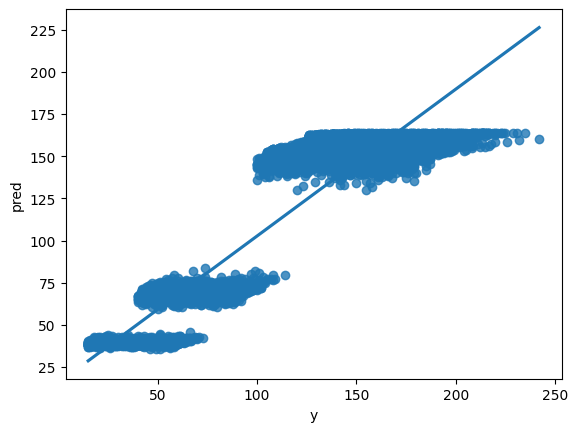

In [ ]:
sns.regplot(x="y", y="pred", data=train_preds_df)


<Axes: xlabel='y', ylabel='pred'>

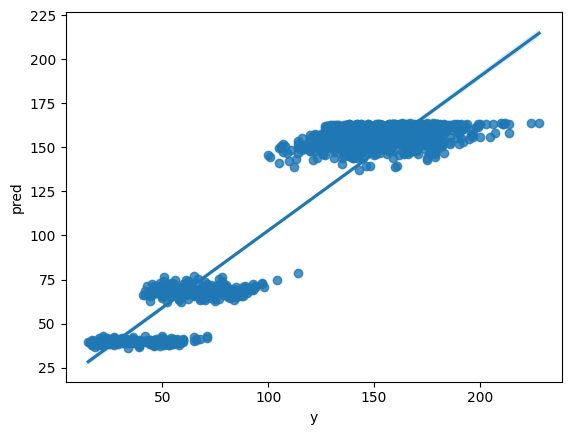

In [ ]:
sns.regplot(x="y", y="pred", data=test_preds_df)

In [ ]:
mean_absolute_error(test_preds_df['y'], test_preds_df['pred']), mean_absolute_error(train_preds_df['y'], train_preds_df['pred'])

(15.58722497177124, 16.218662262386747)